In [1]:
# We have preprocessed the data, and previously written out the architecture. Let's import the data here and rewrite the model here. The model will now have to be trained first with frozen layer weights and then with unfrozen layer weights.

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2025-07-15 10:47:08.027241: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 10:47:08.063248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-15 10:47:08.063273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-15 10:47:08.064194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 10:47:08.070072: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# First import the train and validation data

X_train = np.load("data/train_input_sub_images/all_train_data.npy")
X_valid = np.load("data/valid_input_sub_images/all_valid_data.npy")

In [4]:
X_train.shape, X_valid.shape

((3640, 13, 30, 30, 3), (910, 13, 30, 30, 3))

In [5]:
y_train = np.load("data/train_out_targets/all_train_targets.npy")
y_valid = np.load("data/valid_out_targets/all_valid_targets.npy")

In [6]:
y_train.shape, y_valid.shape

((3640, 7, 32), (910, 7, 32))

In [7]:
# Let's redefine the model here

In [8]:
# We need our CNN model
CNN_model = tf.keras.models.load_model('../../Spring_2024/Bayes_for_comps/TS_bayes_implementation_for_TN/models/trained_gmp_model_dense_32_new.h5')

2025-07-15 10:47:10.716228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [9]:
# Define the reduced model

# last layer
output_reduced = CNN_model.layers[-11].output

reduced_model = tf.keras.models.Model(inputs = CNN_model.input, outputs = output_reduced)

reduced_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                             

In [10]:
# okay, now need to add back the dropout, the dense and activation

# add dropout
added_dropout = tf.keras.layers.Dropout(0.5, name = "New_dropout_0")(CNN_model.layers[-11].output)

# add global max pooling
added_flatten = tf.keras.layers.GlobalMaxPooling2D()(added_dropout)

# add dense
added_dense = tf.keras.layers.Dense(64, name = "New_Dense_0")(added_flatten)

# add activation
added_Act = tf.keras.layers.Activation('relu', name = "New_Activation_0")(added_dense)

# add dropout
added_dropout2 = tf.keras.layers.Dropout(0.5, name = "New_dropout_1")(added_Act)

# # add another dense
added_dense_1 = tf.keras.layers.Dense(32, name = "New_Dense_1")(added_dropout2)

# # add activation
added_Act_1 = tf.keras.layers.Activation('relu', name = "New_Activation_1")(added_dense_1)

new_model = tf.keras.models.Model(CNN_model.input, added_Act_1)

In [11]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                           

In [12]:
# Pass this thorugh the TD layer, and add the rest of the encoder decoder model for our exercise
input_time = 13
feature_size = 32
output_time = 7

# Encoder
# define encoder input
encoder_input = tf.keras.layers.Input(shape = (input_time, None, None, 3)) 

# pass the feature extractor model through a TD layer
td_model = tf.keras.layers.TimeDistributed(new_model)

td_out = td_model(encoder_input)

# add an lstm to process the input sequence
lstm_layer = tf.keras.layers.LSTM(64, activation = "relu", return_state = True, return_sequences = False)

encoder_outputs, state_h, state_c = lstm_layer(td_out)

# Decoder

# repeat the context vector 7 times
decoder_inp = tf.keras.layers.RepeatVector(output_time)(encoder_outputs)

# define an LSTM for the output sequence
decoder_lstm = tf.keras.layers.LSTM(64, return_sequences = True, activation = 'relu')

decoder_out = decoder_lstm(decoder_inp, initial_state = [state_h, state_c])

# TD dense layer to generate the output sequnces
dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(feature_size, activation = 'relu'))

dense_out = dense_layer(decoder_out)

# define the model
CNN_seq2seq_model = tf.keras.models.Model(inputs = encoder_input, outputs = dense_out)

In [13]:
CNN_seq2seq_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed (TimeDist  (None, 13, 32)               71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

In [14]:
# now, we can freeze the laeyr weights of the CNN model (the CNN layers at least)

# freeze the layers
for layer in CNN_model.layers:
    layer.trainable = False

In [15]:
# Final model before unfreezing - verify the required weights are frozen?
CNN_seq2seq_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed (TimeDist  (None, 13, 32)               71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

In [16]:
# Okay, now let's train the frozen model

# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
CNN_seq2seq_model.compile(loss='mean_squared_error', optimizer=opt, metrics = ['mean_absolute_error'])

In [17]:
# add early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, verbose=1, patience=10)

In [18]:
%%time
# Train the model - Maybe we do not need a generator for now, let's see
history = CNN_seq2seq_model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 100, callbacks = [es])

Epoch 1/100


2025-07-15 10:47:14.073064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/time_distributed/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-07-15 10:47:14.459822: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-07-15 10:47:15.927197: I external/local_xla/xla/service/service.cc:168] XLA service 0x14e724ddd3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-15 10:47:15.927232: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2025-07-15 10:47:15.935040: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752594436.046755  207749 device_compiler.h:186] Compi

114/114 [==============================] - 9s 42ms/step - loss: 0.3902 - mean_absolute_error: 0.3320 - val_loss: 0.3827 - val_mean_absolute_error: 0.3102
Epoch 2/100
114/114 [==============================] - 4s 33ms/step - loss: 0.2317 - mean_absolute_error: 0.2288 - val_loss: 0.3505 - val_mean_absolute_error: 0.2890
Epoch 3/100
114/114 [==============================] - 4s 35ms/step - loss: 0.2164 - mean_absolute_error: 0.2135 - val_loss: 0.3185 - val_mean_absolute_error: 0.2725
Epoch 4/100
114/114 [==============================] - 4s 35ms/step - loss: 0.1864 - mean_absolute_error: 0.1959 - val_loss: 0.2956 - val_mean_absolute_error: 0.2610
Epoch 5/100
114/114 [==============================] - 4s 36ms/step - loss: 0.1847 - mean_absolute_error: 0.1940 - val_loss: 0.2922 - val_mean_absolute_error: 0.2590
Epoch 6/100
114/114 [==============================] - 4s 34ms/step - loss: 0.1835 - mean_absolute_error: 0.1929 - val_loss: 0.2748 - val_mean_absolute_error: 0.2501
Epoch 7/100
114/

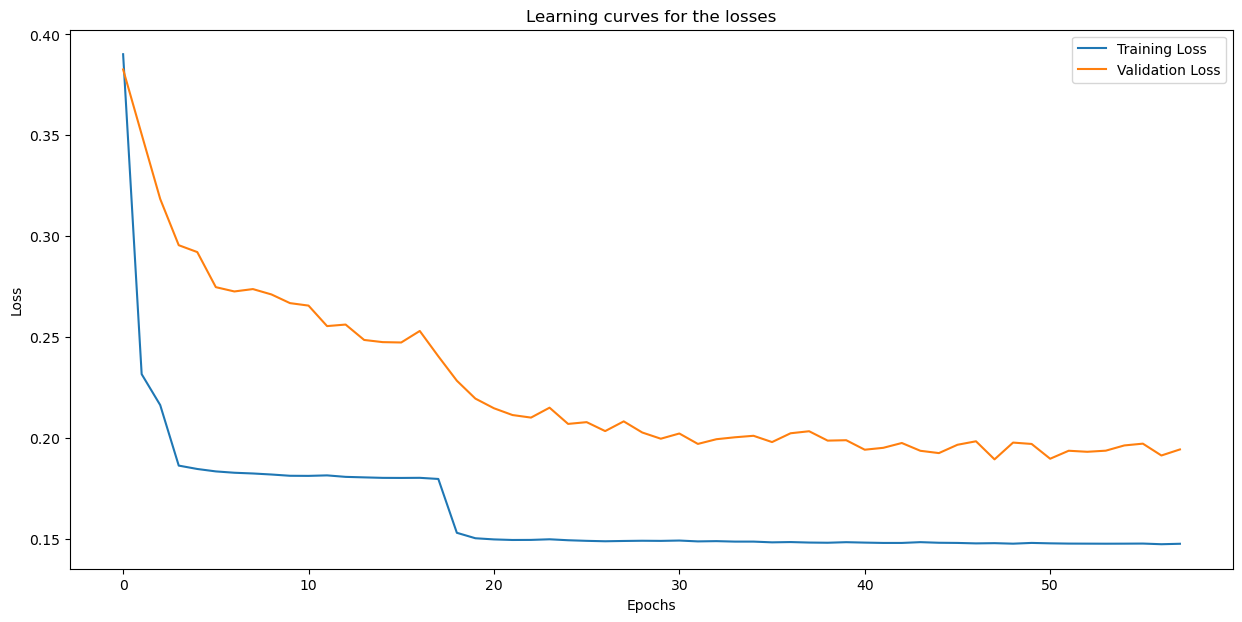

In [19]:
# plot the losses
plt.figure(figsize = (15,7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning curves for the losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# history.history['loss']

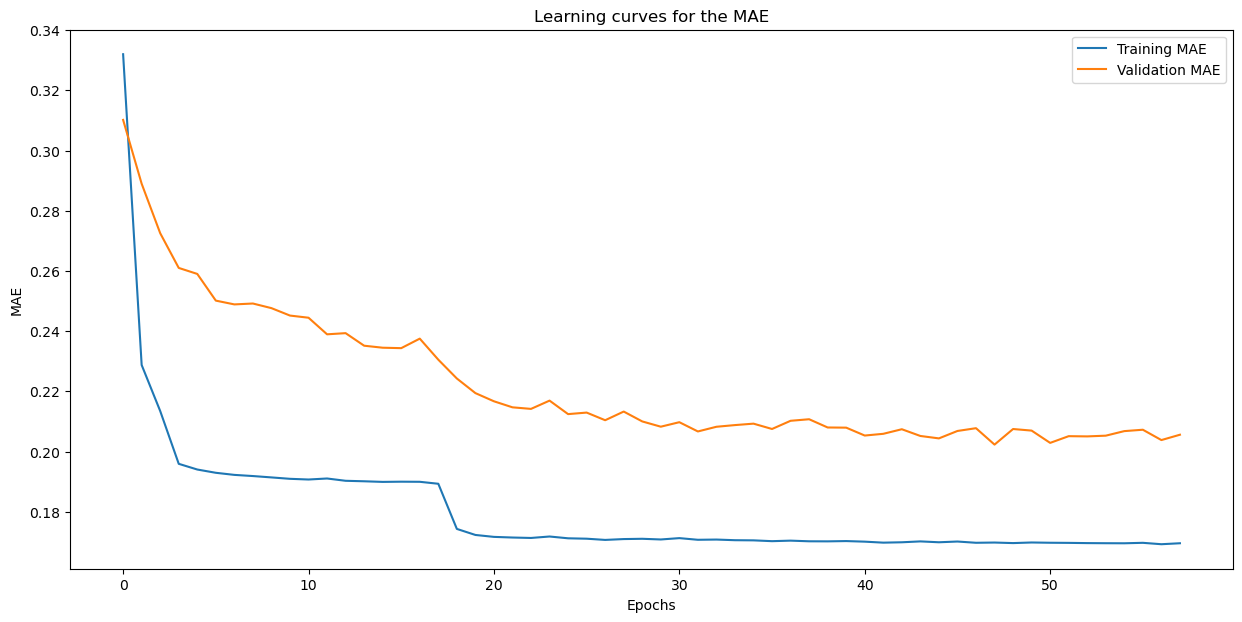

In [20]:
# plot the maes
plt.figure(figsize = (15,7))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title("Learning curves for the MAE")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [21]:
# Now unfreeze the last CNN layer
CNN_model.trainable = True

set_trainable = False

for layer in CNN_model.layers:
    if layer.name == 'conv2d_3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
CNN_seq2seq_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed (TimeDist  (None, 13, 32)               71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

In [23]:
# recompile and train the model

In [24]:
# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0009)
CNN_seq2seq_model.compile(loss='mean_squared_error', optimizer=opt, metrics = ['mean_absolute_error'])

In [25]:
# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, verbose=1, patience=10)

In [26]:
%%time
# Train the model - Maybe we do not need a generator for now, let's see
history_new = CNN_seq2seq_model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 100, callbacks = [es])

Epoch 1/100


2025-07-15 10:51:04.600912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/time_distributed/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


114/114 [==============================] - 7s 39ms/step - loss: 0.1503 - mean_absolute_error: 0.1720 - val_loss: 0.1812 - val_mean_absolute_error: 0.1973
Epoch 2/100
114/114 [==============================] - 4s 34ms/step - loss: 0.1490 - mean_absolute_error: 0.1706 - val_loss: 0.1826 - val_mean_absolute_error: 0.1980
Epoch 3/100
114/114 [==============================] - 4s 34ms/step - loss: 0.1487 - mean_absolute_error: 0.1705 - val_loss: 0.1848 - val_mean_absolute_error: 0.1998
Epoch 4/100
114/114 [==============================] - 4s 34ms/step - loss: 0.1477 - mean_absolute_error: 0.1696 - val_loss: 0.1695 - val_mean_absolute_error: 0.1884
Epoch 5/100
114/114 [==============================] - 4s 34ms/step - loss: 0.1477 - mean_absolute_error: 0.1695 - val_loss: 0.1740 - val_mean_absolute_error: 0.1922
Epoch 6/100
114/114 [==============================] - 4s 33ms/step - loss: 0.1471 - mean_absolute_error: 0.1691 - val_loss: 0.1736 - val_mean_absolute_error: 0.1916
Epoch 7/100
114/

In [27]:
# save this model as keras?

# save this model
model_name_finetuned = 'CNN_seq2seq_non_overlapping.keras'
CNN_seq2seq_model.save('models' + '/' + model_name_finetuned)

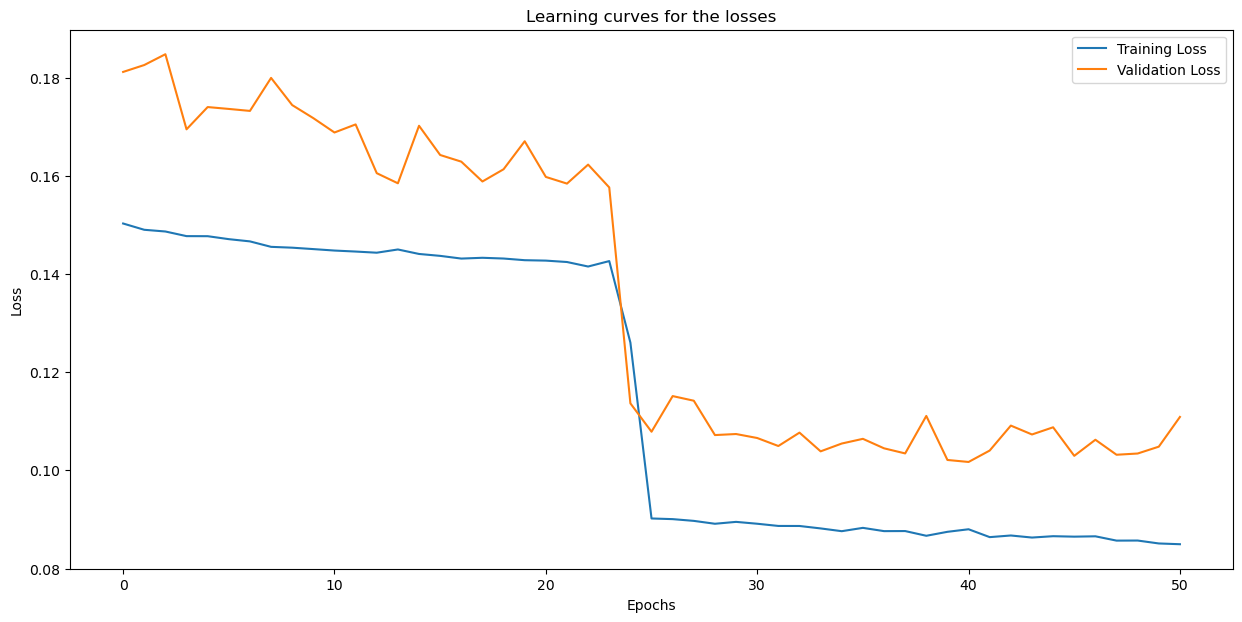

In [28]:
# plot the losses
plt.figure(figsize = (15,7))
plt.plot(history_new.history['loss'], label='Training Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title("Learning curves for the losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# history.history['loss']

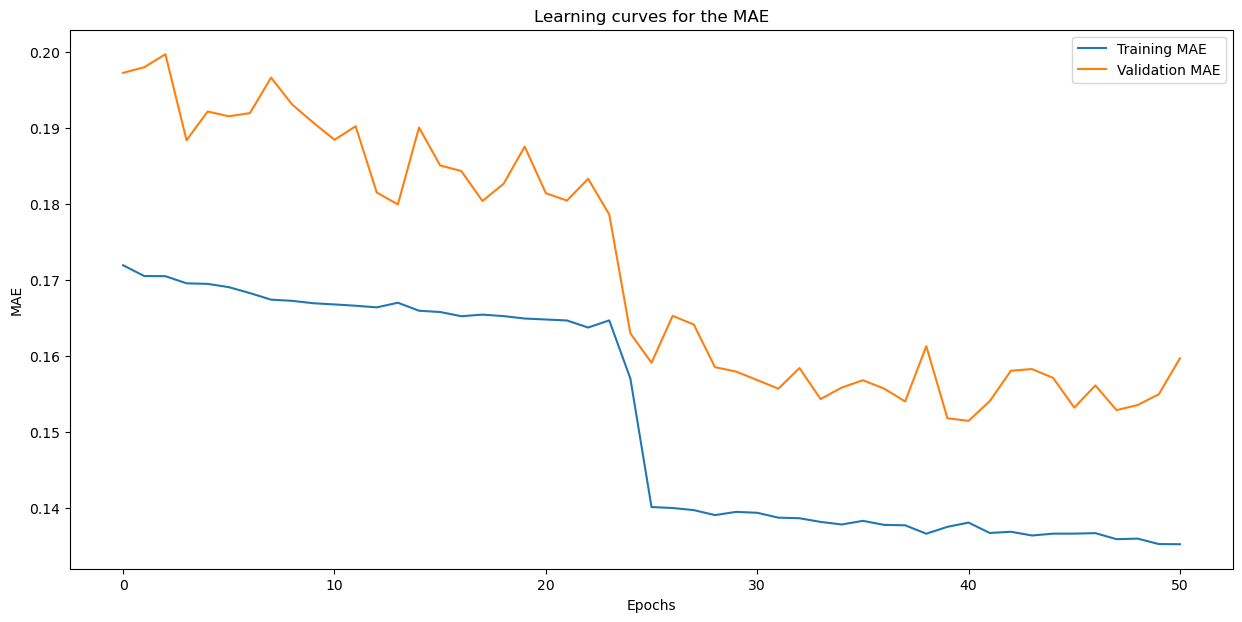

In [29]:
# plot the maes
plt.figure(figsize = (15,7))
plt.plot(history_new.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_new.history['val_mean_absolute_error'], label='Validation MAE')
plt.title("Learning curves for the MAE")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()